In [103]:
# using Pkg
# Pkg.activate("/home/jek354/research/ML-signproblem")
# Pkg.update()

using Lattices
using LinearAlgebra
using Combinatorics
using SparseArrays
using Plots
import Graphs
using LaTeXStrings
using Statistics
using Random
using Zygote
using Optimization, OptimizationOptimisers
using JSON
using OptimizationOptimJL
using JLD2
# using ExponentialUtilities


include("ed_objects.jl")
include("ed_functions.jl")
include("ed_optimization.jl")
include("utility_functions.jl")
include("adiabatic_analysis.jl")

time_ordered_unitary

In [104]:
# using KrylovKit


t = 1.0
U = 6
μ = 0  # positive incentivises fewer particles (one electron costs this much energy)
N_up = 4
N_down = 4
N =  3
half_filling = false
# lattice = Chain(6, Periodic())
lattice_dimension = (2,3)
bc = "periodic"
# lattice = Chain(6, Periodic())
lattice = Square(lattice_dimension, if bc == "periodic" Periodic() else Open() end)
# lattice = Graphs.cycle_graph(3)

models = []

reference_index = 2
# t_values = []# Float64[1,1], Float64[1,0.1], 1.0]
# for _t in t_values
#     # println(_t)
#     push!(models,HubbardModel(_t,0.0001,μ,half_filling))
# end
# U_values = [0.00001,0.01]
U_values = [0.00001; LinRange(2.1,9,20)]
U_values = sort([U_values; 10.0 .^LinRange(-3,2,40)])

for U in U_values
    # println(t)
    push!(models,HubbardModel(t,U,μ,half_filling))
end

subspace = HubbardSubspace(N, lattice)
# subspace = HubbardSubspace(N_up, N_down, lattice)

ops = []
if subspace.N >= 1
    push!(ops,create_operator(subspace,:Sx))
end
push!(ops, create_operator(subspace,:S2))
# op3 = Matrix(create_operator(subspace,:L2))
push!(ops, create_operator(subspace,:T, kind=1))
push!(ops, create_operator(subspace,:T, kind=2))
push!(ops, create_operator(subspace,:σ, kind=1))
E = []
H = []
V = []
# for model ∈ models
#     push!(H, Matrix(create_Hubbard(model, subspace; perturbations=false)))
#     e, v = eigen(H[end])
#     push!(E, e)
#     push!(V, v)
# end

H, indexer = create_Hubbard(models[20], subspace; get_indexer=true)

# eigsolve(H, normalize(rand(size(H)[1])), 1,:SR)

# for i ∈ 1:2
#     println(degeneracy_count(E[i]))
# end

# println(sum(abs.(h1*h2-h2*h1)))

# ops_tmp = [H[1], ops...]
# for i in eachindex(ops_tmp)
#     for j in i+1:length(ops_tmp)
#         println("($i,$j) ", sum(abs.(ops_tmp[i]*ops_tmp[j] - ops_tmp[j]*ops_tmp[i])))
#     end
# end

# H1 = create_Hubbard(model, subspace; perturbations=false)
# E1 = diag(V1'*Matrix(H1)*V1)

# @time degen_rm_U = create_consistent_basis(H, ops;reference_index=reference_index)

# dim = get_subspace_dimension(subspace)
# indexer = CombinationIndexer(reduce(vcat,collect(sites(subspace.lattice))), get_subspace_info(subspace)...)
# difference_dict = collect_all_conf_differences(indexer)


(sparse([1, 2, 3, 5, 7, 12, 1, 2, 4, 9  …  212, 217, 219, 220, 209, 214, 216, 218, 219, 220], [1, 1, 1, 1, 1, 1, 2, 2, 2, 2  …  219, 219, 219, 219, 220, 220, 220, 220, 220, 220], [0.0, -2.0, 1.0, 1.0, 1.0, -1.0, -2.0, 0.0, 1.0, -1.0  …  1.0, 1.0, 0.0, -2.0, 1.0, -1.0, 1.0, 1.0, -2.0, 0.0], 220, 220), CombinationIndexer{Coordinate{2, Int64}}(Coordinate{2, Int64}[Coordinate(1, 1), Coordinate(2, 1), Coordinate(1, 2), Coordinate(2, 2), Coordinate(1, 3), Coordinate(2, 3)], Dict{Tuple{Set{Coordinate{2, Int64}}, Set{Coordinate{2, Int64}}}, Int64}((Set([Coordinate(2, 3), Coordinate(2, 2)]), Set([Coordinate(1, 2)])) => 191, (Set([Coordinate(2, 1)]), Set([Coordinate(1, 3), Coordinate(2, 2)])) => 48, (Set([Coordinate(1, 2)]), Set([Coordinate(1, 3), Coordinate(1, 1)])) => 54, (Set([Coordinate(1, 2), Coordinate(2, 1)]), Set([Coordinate(2, 3)])) => 146, (Set(), Set([Coordinate(1, 1), Coordinate(2, 2), Coordinate(1, 2)])) => 5, (Set([Coordinate(2, 3)]), Set([Coordinate(1, 1), Coordinate(2, 2)])) => 9

In [8]:
t_dict = Dict{Vector{Tuple{Coordinate{2,Int64},Int,Symbol}}, Float64}()

for s1 in indexer.a
    if [(s1, 1,:create), (s1, 1, :annihilate),(s1, 2,:create),(s1, 2, :annihilate)] ∉ keys(t_dict)
        t_dict[[(s1, 1,:create), (s1, 1, :annihilate),(s1, 2,:create),(s1, 2, :annihilate)]] = 1
    else
        t_dict[[(s1, 1,:create), (s1, 1, :annihilate),(s1, 2,:create),(s1, 2, :annihilate)]] += 1
    end
end
rows = Int[]
cols = Int[]
vals = Float64[]
general_n_body!(rows, cols, vals, t_dict, indexer)
H2 = Matrix(sparse(rows, cols, vals, length(degen_rm_U[50][:,97]), length(degen_rm_U[50][:,97])))

state = degen_rm_U[50][:,97]
state'*H2*state
# indexer.inv_comb_dict[argmax(diag(H2))]

3

In [ ]:
include("ed_functions.jl")
t_dict = create_randomized_nth_order_operator(1, indexer; hermitian=false, conserve_spin=false)
inv_param_map, param_map = find_symmetry_groups(collect(keys(t_dict)), size(lattice)...,  trans_x=false, trans_y=true, hermitian=true)
collect(keys(t_dict))[inv_param_map[2]]

6-element Vector{Vector{Tuple{Coordinate{2, Int64}, Int64, Symbol}}}:
 [(Coordinate(2, 2), 2, :create), (Coordinate(2, 3), 1, :annihilate)]
 [(Coordinate(2, 1), 2, :create), (Coordinate(2, 2), 1, :annihilate)]
 [(Coordinate(2, 1), 1, :create), (Coordinate(2, 3), 2, :annihilate)]
 [(Coordinate(2, 2), 1, :create), (Coordinate(2, 1), 2, :annihilate)]
 [(Coordinate(2, 3), 2, :create), (Coordinate(2, 1), 1, :annihilate)]
 [(Coordinate(2, 3), 1, :create), (Coordinate(2, 2), 2, :annihilate)]

In [ ]:
include("ed_functions.jl")
t_dict = create_randomized_nth_order_operator(2, indexer; conserve_spin=false)
inv_param_map, param_map, parity = find_symmetry_groups(collect(keys(t_dict)), size(lattice)..., 
    hermitian=true,  trans_x=true, trans_y=true, refl_x=false, refl_y=true)
rows, cols, signs, ops_list = build_n_body_structure(t_dict, indexer)
param_index_map = build_param_index_map(ops_list, collect(keys(t_dict)))
reduced = rand(typeof(signs[1]), length(inv_param_map))
# reduced .= 0.0
# # reduced[1] = 1.5
# reduced[2] = 1.0
dim = length(indexer.inv_comb_dict)
vals = update_values(signs, param_index_map,reduced, param_map, parity)
new_rows = []
new_cols = []
new_vals = ComplexF64[]
for i in eachindex(vals)
    if !(vals[i] ≈ 0)
        push!(new_rows, rows[i])
        push!(new_cols, cols[i])
        push!(new_vals, vals[i])
    end
end
# println(new_rows)
# println(new_cols)
# println(new_vals)
# println(Matrix(sparse(new_rows, new_cols, new_vals, dim, dim)))
op = Matrix(sparse(new_rows,new_cols, new_vals, dim, dim))
# op*ops[2] .- ops[2]*op
for i=3:5
    println(sum(abs,ops[i]*op - op*ops[i]))
end
# for i in eachindex(rows)
#     if rows[i] != cols[i] && !(x[cols[i], rows[i]] ≈ 0)
#         println("Bad: $i $(x[cols[i], rows[i]]) $(x[rows[i], cols[i]])")
#     end
# end

8.881784197001252e-15
1.0867811519599071e-14
8.881784197001252e-15


In [7]:
# state = degen_rm_U[1][:,1]
k = 50
args = correlation_matrix(1, indexer)
for i in axes(V[1][:,1:100],2)
    state1 = degen_rm_U[1][:,i]
    state2 = degen_rm_U[k][:,i]
    U_value = U_values[k]
    energy = real.(diag(degen_rm_U[k]'*H[k]*degen_rm_U[k])[i])
    println("state #:$i U=$U_value energy: $(energy) \t U=0,!=0 SD?:$(is_slater_determinant(state1, indexer; correlation_args=args)) $(is_slater_determinant(state2, indexer; correlation_args=args))   \t overlap: $(real(degen_rm_U[1][:,i]'*degen_rm_U[k][:,i]))")
end
# γ = compute_correlation(state, 1, indexer)
# println("rank(γ)=$(rank(γ))  sum(γ^2 -γ)=$(sum(abs.(γ^2-γ)))")
# eigvals(Matrix(mats[4,4]))

state #:1 U=8.273684210526316 energy: -0.9999999999999999 	 U=0,!=0 SD?:false false   	 overlap: 0.9999999999999998
state #:2 U=8.273684210526316 energy: 4.99999999999999 	 U=0,!=0 SD?:false false   	 overlap: 0.9999999999999987
state #:3 U=8.273684210526316 energy: 1.9999999999999993 	 U=0,!=0 SD?:false false   	 overlap: 1.0
state #:4 U=8.273684210526316 energy: -1.999999999999999 	 U=0,!=0 SD?:false false   	 overlap: 0.9999999999999993
state #:5 U=8.273684210526316 energy: 5.999999999999998 	 U=0,!=0 SD?:false false   	 overlap: 0.9999999999999994
state #:6 U=8.273684210526316 energy: -1.9999999999999991 	 U=0,!=0 SD?:false false   	 overlap: 1.0
state #:7 U=8.273684210526316 energy: -1.999999999999999 	 U=0,!=0 SD?:false false   	 overlap: 0.9999999999999996
state #:8 U=8.273684210526316 energy: 13.92041225692679 	 U=0,!=0 SD?:false false   	 overlap: 0.8514029641263088
state #:9 U=8.273684210526316 energy: 10.854818110491724 	 U=0,!=0 SD?:false false   	 overlap: 0.71016992031134

In [12]:
d = load("data/pruning_analysis2.jld2")

Dict{String, Any} with 5 entries:
  "error_data"          => [0.0 0.0 … 7.75328e-11 0.0; 0.0 0.0 … 7.75328e-11 0.…
  "U_values"            => [1.0e-5, 0.001, 0.0013434, 0.00180472, 0.00242446, 0…
  "removed_terms"       => [0.0 0.0 … 1.0 0.0; 0.0 0.0 … 2.0 0.0; … ; 0.0 0.0 ……
  "original_error_data" => [0.0, 0.0, 0.0, 0.0, 0.0, 6.32827e-15, 7.10543e-15, …
  "thresholds"          => [1.0e-10, 1.99526e-10, 3.98107e-10, 7.94328e-10, 1.5…

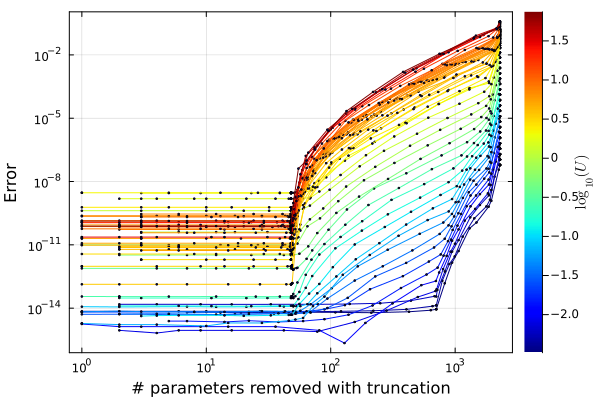

In [18]:
cmap = cgrad(:jet1, 30, categorical=false)
p = plot( xlabel="# parameters removed with truncation", ylabel="Error", colorbar_title=L"\log_{10}(U)", framestyle=:box,
    yticks=10.0 .^ (-20:3:0), xticks=10.0 .^ (-0:3), yscale=:log10, xscale=:log10, )
# )

for i=6:61
    filt = d["removed_terms"][:,i] .> 0
    # println(d["removed_terms"][:,i][filt])
    plot!(p,d["removed_terms"][:,i][filt],max.(abs.(d["error_data"][:,i][filt]),1e-16), line_z=log10.(repeat([d["U_values"][i]],sum(filt))),color=cmap, label=nothing, marker=:circle, markersize=1)
end
display(p)
# savefig("single_state_map_images2/pruning_analysis3_nonlogscale.png")

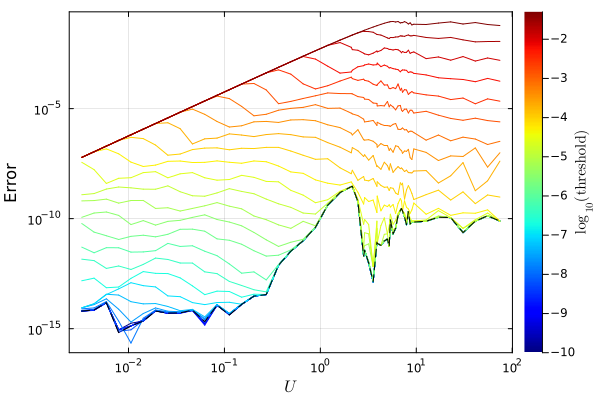

In [22]:

p = plot(xlabel=L"U", ylabel="Error", colorbar_title=L"\log_{10}(\mathrm{threshold})", framestyle=:box,
        xscale=:log10, yscale=:log10, xticks=10.0 .^ (-3:2),)
# )
cmap = cgrad(:jet1, 30, categorical=false)
for i in 1:30
    plot!(p, d["U_values"][6:end-1], max.(abs.(d["error_data"][i,6:end-1]),1e-16),line_z=log10.(repeat([d["thresholds"][i]],length(d["U_values"][6:end-1]))), 
        color=cmap, label=nothing)
end
plot!(p,d["U_values"][6:end-1], max.(abs.(d["original_error_data"][6:end-1]),1e-16), color=:black, linestyle=:dash, label=nothing)
# plot(p, p2, layout=l)
display(p)
# savefig(p, "single_state_map_images2/pruning_analysis2_nologscale.png")


In [42]:
include("ed_objects.jl")
include("ed_functions.jl")
include("ed_optimization.jl")
include("utility_functions.jl")

dic = load_saved_dict("data/N=3/meta_data_and_E.jld2")

meta_data = dic["meta_data"]
U_values = meta_data["U_values"]
all_eig_vecs = dic["all_eig_vecs"]
mapping = dic["mapping"]
s_mapping = dic["s_mapping"]
representative_indices = dic["representative_indices"]
magnitude = dic["magnitude"]
eig_indices = meta_data["translational symmetry"]
n_eigs = [parse(Int,x) for x in split(meta_data["sites"], "x")]
degen_rm_U = reconstruct_full_vector(
     all_eig_vecs, 
     mapping, s_mapping, representative_indices, magnitude, eig_indices, n_eigs
)

# # meta_data = Dict("electron count"=>3, "sites"=>"2x3", "bc"=>"periodic", "basis"=>"adiabatic", 
# #                 "U_values"=>U_values, "maxiters"=>10)
# instructions = Dict("starting state"=>Dict("U index"=>1, "levels"=>1),
#                 "ending state"=>Dict("U index"=>20, "levels"=>1), "max_order"=>2, "use symmetry"=>false)
# println("U in [",U_values[instructions["starting state"]["U index"]], ", ", U_values[instructions["ending state"]["U index"]],"]")
# data_dict_tmp = test_map_to_state(degen_rm_U, instructions, indexer, !isa(meta_data["electron count"], Number);
#      maxiters=meta_data["maxiters"], optimization=:gradient)
# data_dict_tmp
# # save_with_metadata(data_dict_tmp, "data/tmp.jld2")

61×220 Matrix{ComplexF64}:
 -1.22831e-16-3.24004e-17im  …   9.97506e-17+2.48169e-17im
  9.19074e-18+7.69739e-18im      -3.3501e-17-1.16391e-17im
  4.88804e-19-2.54496e-18im     -3.01656e-18-1.45841e-18im
  1.75584e-18+5.48011e-19im     -5.27849e-18+4.57928e-18im
 -5.47151e-19-7.3968e-18im      -2.59641e-18+3.4928e-18im
 -7.53698e-18+5.28362e-18im  …   4.71977e-18+2.52354e-18im
 -5.15034e-18+5.13814e-18im        1.395e-18+3.94126e-18im
  9.53047e-18+3.28715e-18im     -7.90127e-18-5.82535e-18im
  1.78187e-17-1.85231e-17im      1.80415e-18+3.97186e-19im
  1.36206e-17-6.91252e-18im     -9.90224e-19+3.51981e-17im
             ⋮               ⋱  
    4.185e-17-1.11877e-17im     -2.44488e-17-1.317e-17im
  5.91832e-17+1.00048e-16im     -2.54924e-17-2.26294e-17im
  1.00476e-16+1.96367e-17im     -1.42252e-17-5.18836e-17im
   6.5966e-16-4.22262e-16im  …  -2.63187e-17-3.88373e-16im
  4.25195e-17-1.5397e-17im      -1.62163e-17+3.31198e-17im
 -2.38586e-17-2.19758e-17im      3.94411e-18+2.6021e-17im


In [104]:
i = 218
energy_dict = load_saved_dict(joinpath(raw"C:\Users\jonat\Downloads\N=3","meta_data_and_E.jld2"))
data_dict_tmp = load_saved_dict(joinpath(raw"C:\Users\jonat\Downloads\N=3","unitary_map_energy_N=3_$i.jld2"))
starting_U_level = data_dict_tmp["labels"][1]["starting state"]["level"]
starting_U_index = data_dict_tmp["labels"][1]["starting state"]["U index"]
ending_U_level = data_dict_tmp["labels"][1]["ending state"]["level"]
ending_U_index = data_dict_tmp["labels"][1]["ending state"]["U index"]
H = energy_dict["H"]
println("index: $starting_U_index -> $ending_U_index")
println("level: $starting_U_level -> $ending_U_level")



index: 1 -> 34
level: 58 -> 58


In [125]:
function encode_operators(opstrings)
    n_ops = length(opstrings)

    # Count total number of elementary operators
    total_terms = sum(length, opstrings)

    # Flat storage
    xs      = Vector{Int}(undef, total_terms)
    ys      = Vector{Int}(undef, total_terms)
    spins   = Vector{Int}(undef, total_terms)
    actions = Vector{Int}(undef, total_terms)

    # Offsets to reconstruct each operator string
    offsets = Vector{Int}(undef, n_ops + 1)
    offsets[1] = 1

    idx = 1
    for (i, ops) in enumerate(opstrings)
        for (coord, spin, act) in ops
            xs[idx] = coord.coordinates[1]
            ys[idx] = coord.coordinates[2]
            spins[idx] = spin
            actions[idx] = act === :create ? 1 : -1
            idx += 1
        end
        offsets[i+1] = idx
    end

    return (
        xs = xs,
        ys = ys,
        spins = spins,
        actions = actions,
        offsets = offsets
    )
end

encoded = encode_operators(data_dict_tmp["coefficient_labels"][order])
h5open("data/operators.h5", "w") do f
    for order = 1:2
        f["/$order/x"]       = encoded.xs
        f["/$order/y"]       = encoded.ys
        f["/$order/spin"]    = encoded.spins
        f["/$order/action"]  = encoded.actions
        f["/$order/offsets"] = encoded.offsets
        f["/$order/coefficient"] = data_dict_tmp["coefficients"][1][order]
    end
end


In [114]:
data_dict_tmp["coefficients"][1][2]

2211-element Vector{Float64}:
  0.013938848477667043
 -0.008143545392378953
 -0.003944684471552566
 -0.00843208115376788
 -0.025343680481885855
  0.004047947579309976
 -0.012420459826880483
 -0.002567471874217044
  0.01099605202606863
 -0.016203633974513982
  ⋮
  0.01143247427514072
  0.0169667987335846
  0.023389985970558257
 -0.016612323539711222
 -0.004695879119844006
  0.013902736620079972
 -0.002536576510839753
  0.004071547659087768
 -0.006351285014589584

In [111]:
using HDF5
h5open("./data/N=3_actuallyn3.h5", "w") do file
    write(file, "E", stack(energy_dict["E"]))
    write(file, "degen_rm_U", stack(energy_dict["degen_rm_U"]))
    write(file, "H", stack(energy_dict["H"]))
    write(file, "V", stack( energy_dict["V"]))
    write(file, "U_values", energy_dict["meta_data"]["U_values"])
    # fid["degen_rm_U"] = energy_dict["degen_rm_U"]
    # fid["H"] = energy_dict["H"]
    # fid["V"] = energy_dict["V"]
end

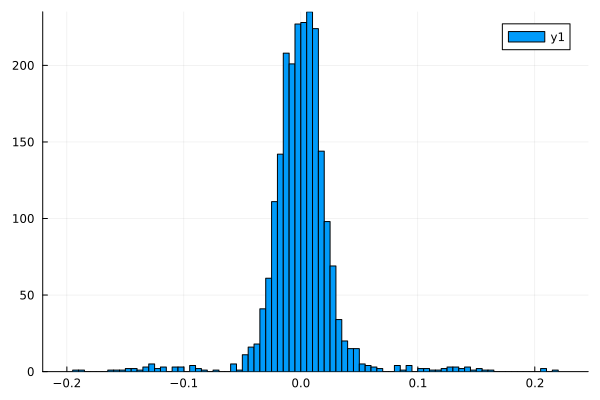

In [47]:
histogram(truncate.(data_dict_tmp["coefficients"][1][2], 1e-8), bins=100)

In [ ]:
heatmap(Matrix(abs.(data_dict_tmp["all_matrices"][1][2])), cmap=:grays)

In [ ]:
histogram(Matrix(data_dict_tmp["all_matrices"][1][2])[:], bins=100, yscale=:log10)

In [ ]:
function extract_creates_and_annihilates(term)
    creates = [(op[1].coordinates..., op[2]) for op in term if op[3] == :create]
    annihilates = [(op[1].coordinates..., op[2]) for op in term if op[3] == :annihilate]
    return creates, annihilates
end
function sort_labels(arr::Vector{<:AbstractVector{<:Tuple}})
    # println(arr[1])
    # println(hcat([reverse(collect(u)) for u in arr[1]]...)'[:])
    sort(arr; by = x-> hcat([reverse(collect(u)) for u in x]...)'[:])
end

# using StatsBase
unzip(a) = map(x->getfield.(a, x), fieldnames(eltype(a)))
function heatmap_terms(info, weights; Lx=2, Ly=3)
    labels = Dict()
    creates,_ = unzip(info)

    # println(info[1][1])
    d = unique(creates)
    d = sort_labels(d)
    for (i,c) in enumerate(d)
        labels[c] = i
    end
    # display(d)
    mat = zeros(length(values(labels)), length(values(labels)))
    

    for ((label1, label2), w) in zip(info, weights)
        mat[labels[label1], labels[label2]] = w
        if mat[labels[label2], labels[label1]] ≈ 0 && labels[label2] != labels[label1]
            mat[labels[label2], labels[label1]] = w
        elseif labels[label2] != labels[label1]
            println("woah override")
        end

    end
    mat

end

for (i, (label, ax_label)) in enumerate(zip(["A^{(1)}_{ij}","A^{(2)}_{ijkl}"],[["i","j"], ["(i,j)","(k,l)"]]))
    
    p1 = histogram(data_dict_tmp["coefficients"][1][i], legend=nothing,
        xlabel=L"%$label", ylabel="Count", title=L"$%$label$ values", framestyle=:box)
    # println(ax_label[1])
    mat = heatmap_terms([extract_creates_and_annihilates(t) for t in data_dict_tmp["coefficient_labels"][i]], data_dict_tmp["coefficients"][1][i]; Lx=2, Ly=3)
    upper_bound = maximum(abs, mat)
    p2 = heatmap(mat; colormap=:seismic, clims=(-upper_bound, upper_bound),
            title=L"$%$label$ amplitudes between sites",
            xlabel=L"Creation sites $%$(ax_label[1])$", ylabel=L"Annihilation sites $%$(ax_label[2])$"
            )
    display(p1)
    display(p2)
    # for filetype in ["png", "svg", "pdf"]
    #     savefig(p1, "single_state_map_images/$(label)_histogram_differentE.$filetype")
    #     savefig(p2, "single_state_map_images/$(label)_heatmap_differentE.$filetype")
    # end
end


In [ ]:
for (i, label) in enumerate(["A^{(1)}_{ij}","A^{(2)}_{ijkl}"])
    
    p = histogram(data_dict_tmp["coefficients"][1][i], legend=nothing,
        xlabel=L"%$label", ylabel="Count", title=L"$%$label$ values")
    display(p)
    for filetype in ["png", "svg", "pdf"]
        savefig(p, "single_state_map_images/$(label)_histogram.$filetype")
    end
end

In [ ]:
for (label, i) in zip(["A^{(1)}_{ij}","A^{(2)}_{ijkl}"], 1:2)
    data = vec(data_dict_tmp["all_matrices"][1][i])
    filt = abs.(data) .> 0
    p1=histogram(data[filt], bins=100, yaxis=:log10, xlabel=L"%$label", ylabel="Count", legend=nothing, title=L"Non-zero $%$label$ values")
    display(p1)
    p2=histogram(data, bins=100, yaxis=:log10, xlabel=L"%$label", ylabel="Count", legend=nothing, title=L"All $%$label$ values")
    display(p2)
    println(1-sum(filt)/length(data))
    # for filetype in ["png", "svg", "pdf"]
    #     savefig(p1, "single_state_map_images/$(label)_histogram_withoutzero.$filetype")
    #     savefig(p1, "single_state_map_images/$(label)_histogram.$filetype")
    # end
end

In [ ]:
data = Matrix(data_dict_tmp["all_matrices"][1][1])
max_val = maximum(abs.(data))
p1 = heatmap(data, 
    xlabel=L"i", ylabel=L"j", title=L"A^{(1)}_{ij}", cmap=:seismic, 
    clims=(-max_val, max_val))
p2= heatmap(Matrix(data_dict_tmp["all_matrices"][1][2]), xlabel=L"(i,j)", ylabel=L"(k,l)", title=L"A^{(2)}_{ijkl}", cmap=:seismic)
for filetype in ["png", "svg", "pdf"]
    savefig(p1, "single_state_map_images/A^{(1)}_{ij})_heatmap.$filetype")
    savefig(p2, "single_state_map_images/A^{(2)}_{ijkl}_heatmap.$filetype")
end

In [8]:
# pruning study
# folder = "/media/jonathon/Jonathon HDD/datasets/HubbardED/N=3" #
folder = raw"C:\Users\jonat\Downloads\N=3"
energy_meta_data_dict = load_saved_dict(joinpath(folder,"meta_data_and_E.jld2"))
degen_rm_U = energy_meta_data_dict["degen_rm_U"]
H = energy_meta_data_dict["H"]
U_values = energy_meta_data_dict["meta_data"]["U_values"]
data = merge_jld2_folder(folder; 
    include_keys=["coefficients", "coefficient_labels", "labels", "all_matrices"], 
    file_filter=[dic -> dic["labels"][1]["starting state"]["level"] == 58 && dic["labels"][1]["ending state"]["level"] == 58],
    verbose=true)

thresholds = 10.0 .^(-10:0.3:0)
# error_data = zeros(length(thresholds), length(U_values))
# original_error_data = zeros(length(U_values))
removed_terms = zeros(length(thresholds), length(U_values))

for k in eachindex(data["coefficients"])
    starting_U_level = data["labels"][1]["starting state"]["level"]
    starting_U_index = data["labels"][1]["starting state"]["U index"]
    ending_U_level = data["labels"][k]["ending state"]["level"]
    ending_U_index = data["labels"][k]["ending state"]["U index"]

    mat_accurate = Matrix(sum(data["all_matrices"][k]))
    found_u_index = data["labels"][k]["ending state"]["U index"]
    n1_overlap_true = energy_meta_data_dict["degen_rm_U"][ending_U_index][:,ending_U_level]' * exp(1im*mat_accurate) * energy_meta_data_dict["degen_rm_U"][starting_U_index][:,starting_U_level]
    # original_error_data[found_u_index] = 1-abs2(n1_overlap_true)
    for (l,threshold) in enumerate(thresholds)
        println("($l,$k) of ($(length(thresholds)), $(length(U_values)))")
        
        removed_terms[l,found_u_index] = sum(sum(abs.(data["coefficients"][k][i]) .< threshold) for i=1:2)
        # println(sum(sum(abs.(data_dict_tmp["coefficients"][1][i]) .< 1e-3) for i=1:2)/sum())

        # n1_overlap = energy_meta_data_dict["degen_rm_U"][ending_U_index][:,ending_U_level]' * exp(1im*mat) * energy_meta_data_dict["degen_rm_U"][starting_U_index][:,starting_U_level]
        # # println(found_u_index)
        # error_data[l,found_u_index]  = 1-abs2(n1_overlap)
    end
end



loaded: 20/526
loaded: 40/526
loaded: 60/526
loaded: 80/526
loaded: 100/526
loaded: 120/526
loaded: 140/526
loaded: 160/526
loaded: 180/526
loaded: 200/526
loaded: 220/526
loaded: 240/526
loaded: 260/526
loaded: 280/526
loaded: 300/526
loaded: 320/526
loaded: 340/526
loaded: 360/526
loaded: 380/526
loaded: 400/526
loaded: 420/526
loaded: 440/526
loaded: 460/526
loaded: 480/526
loaded: 500/526
loaded: 520/526
(1,1) of (34, 61)
(2,1) of (34, 61)
(3,1) of (34, 61)
(4,1) of (34, 61)
(5,1) of (34, 61)
(6,1) of (34, 61)
(7,1) of (34, 61)
(8,1) of (34, 61)
(9,1) of (34, 61)
(10,1) of (34, 61)
(11,1) of (34, 61)
(12,1) of (34, 61)
(13,1) of (34, 61)
(14,1) of (34, 61)
(15,1) of (34, 61)
(16,1) of (34, 61)
(17,1) of (34, 61)
(18,1) of (34, 61)
(19,1) of (34, 61)
(20,1) of (34, 61)
(21,1) of (34, 61)
(22,1) of (34, 61)
(23,1) of (34, 61)
(24,1) of (34, 61)
(25,1) of (34, 61)
(26,1) of (34, 61)
(27,1) of (34, 61)
(28,1) of (34, 61)
(29,1) of (34, 61)
(30,1) of (34, 61)
(31,1) of (34, 61)
(32,1) o

In [10]:
save(raw"data/pruning_analysis2.jld2", 
    Dict(
        "error_data"=>error_data, 
        "original_error_data"=>original_error_data, 
        "thresholds"=>thresholds, 
        "U_values"=>U_values, 
        "removed_terms"=>removed_terms
        )
)

In [24]:
folder = raw"C:\Users\jonat\Downloads\N=3"
energy_meta_data_dict = load_saved_dict(joinpath(folder,"meta_data_and_E.jld2"))
degen_rm_U = energy_meta_data_dict["degen_rm_U"]
H = energy_meta_data_dict["H"]
U_values = energy_meta_data_dict["meta_data"]["U_values"]
data = merge_jld2_folder(folder; 
    include_keys=["norm1_metrics", "loss_metrics", "labels", "other_metrics"], 
    file_filter=[dic -> dic["labels"][1]["starting state"]["level"] == 58 && dic["labels"][1]["ending state"]["level"] == 46],
    verbose=true)

loaded: 20/526
loaded: 40/526
loaded: 60/526
loaded: 80/526
loaded: 100/526
loaded: 120/526
loaded: 140/526
loaded: 160/526
loaded: 180/526
loaded: 200/526
loaded: 220/526
loaded: 240/526
loaded: 260/526
loaded: 280/526
loaded: 300/526
loaded: 320/526
loaded: 340/526
loaded: 360/526
loaded: 380/526
loaded: 400/526
loaded: 420/526
loaded: 440/526
loaded: 460/526
loaded: 480/526
loaded: 500/526
loaded: 520/526


Dict{String, Any} with 4 entries:
  "loss_metrics"  => Any[Any[1.0, 0.287614, 9.03722e-14], Any[1.0, 0.287625, 1.…
  "labels"        => Any[Dict("starting state"=>Dict("U index"=>1, "level"=>58)…
  "other_metrics" => Vector{Any}[[ * Status: failure…
  "norm1_metrics" => Any[[1394.27, 1143.07], [1926.13, 1284.73], [1476.86, 147.…

In [30]:
fieldnames(typeof(data["other_metrics"][1][1]))

(:method, :initial_x, :minimizer, :minimum, :iterations, :x_abstol, :x_reltol, :x_abschange, :x_relchange, :f_abstol, :f_reltol, :f_abschange, :f_relchange, :g_abstol, :g_residual, :trace, :f_calls, :g_calls, :h_calls, :time_limit, :time_run, :stopped_by, :termination_code)

In [67]:
data["other_metrics"][40][2].time_run

211.8391089439392

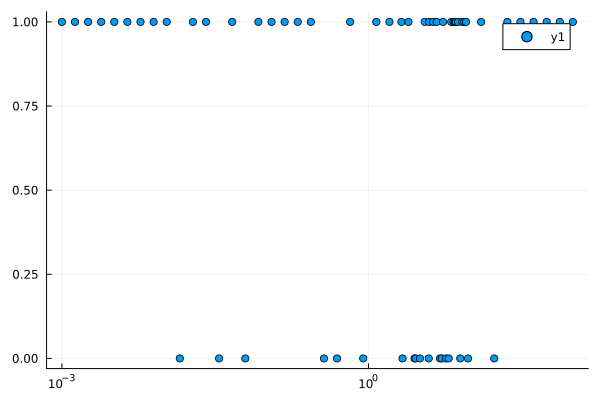

In [59]:
scatter(U_values[2:end],Float64.([data["other_metrics"][i][1].stopped_by[:callback] for i in eachindex(U_values[2:end])]), xscale=:log10)

In [49]:
p = plot(U_values, Float64.([data["other_metrics"][i][1].stopped_by[:callback] for i in eachindex(U_values[2:end])]))
display(p)

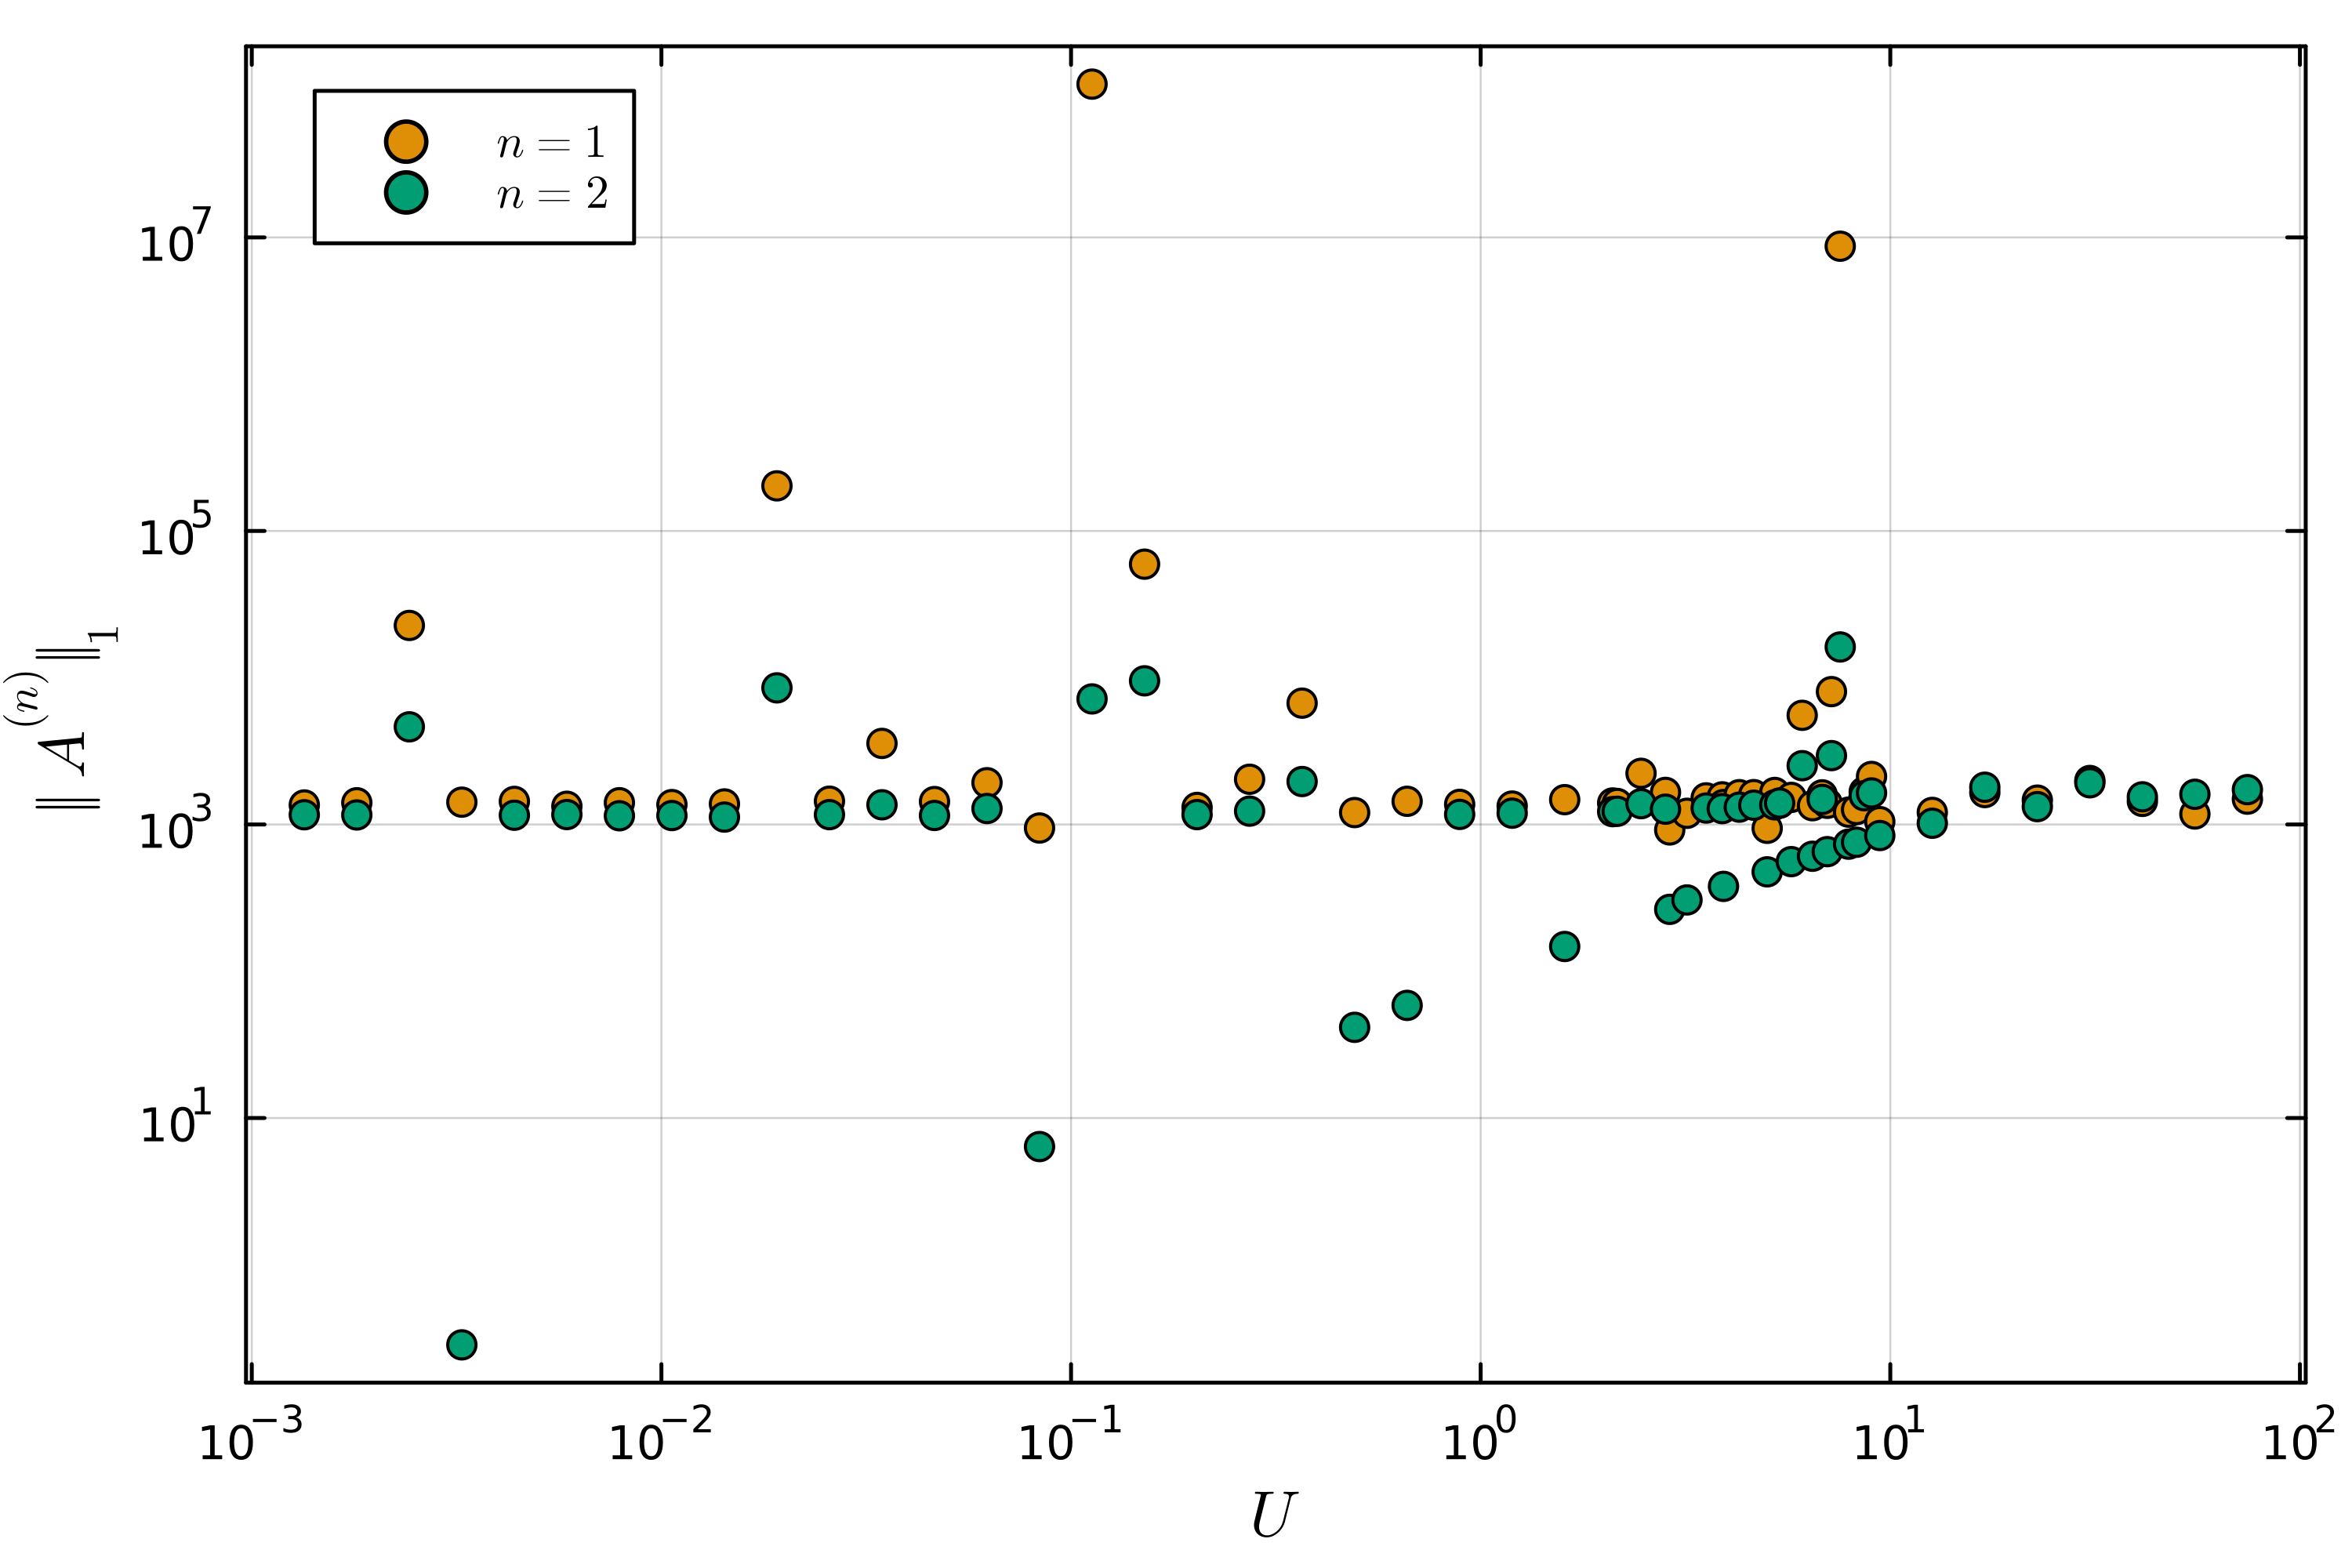

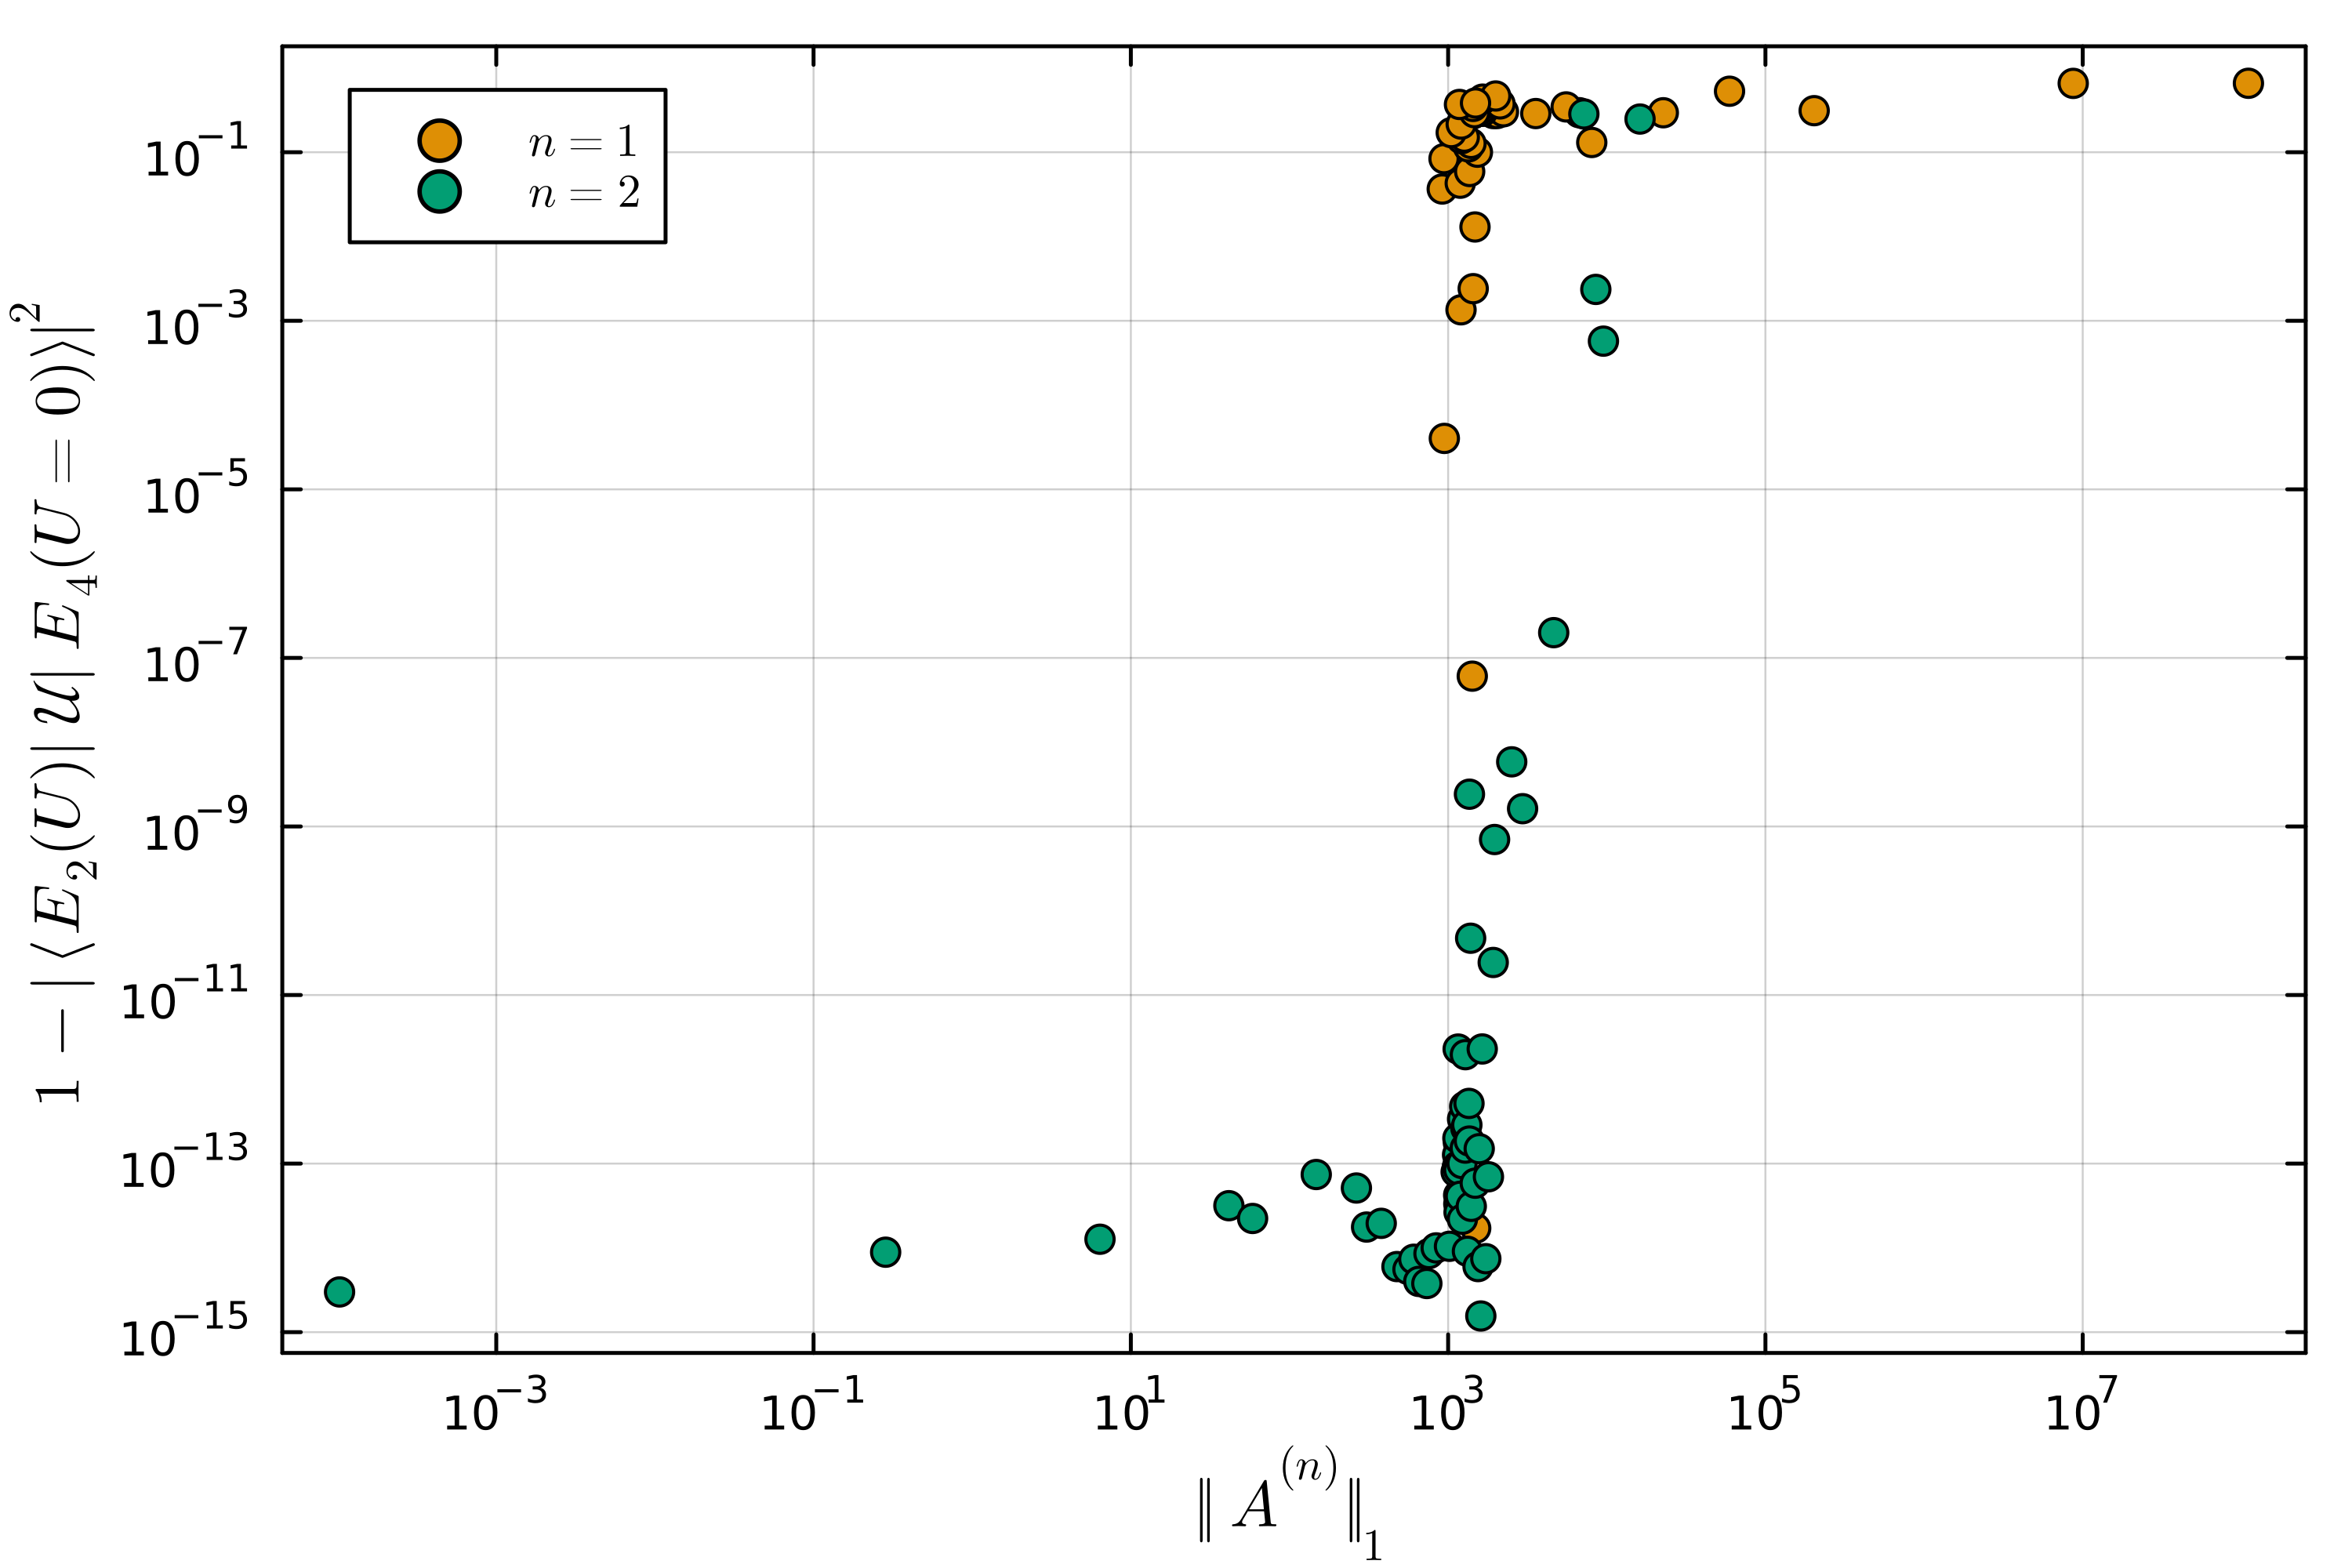

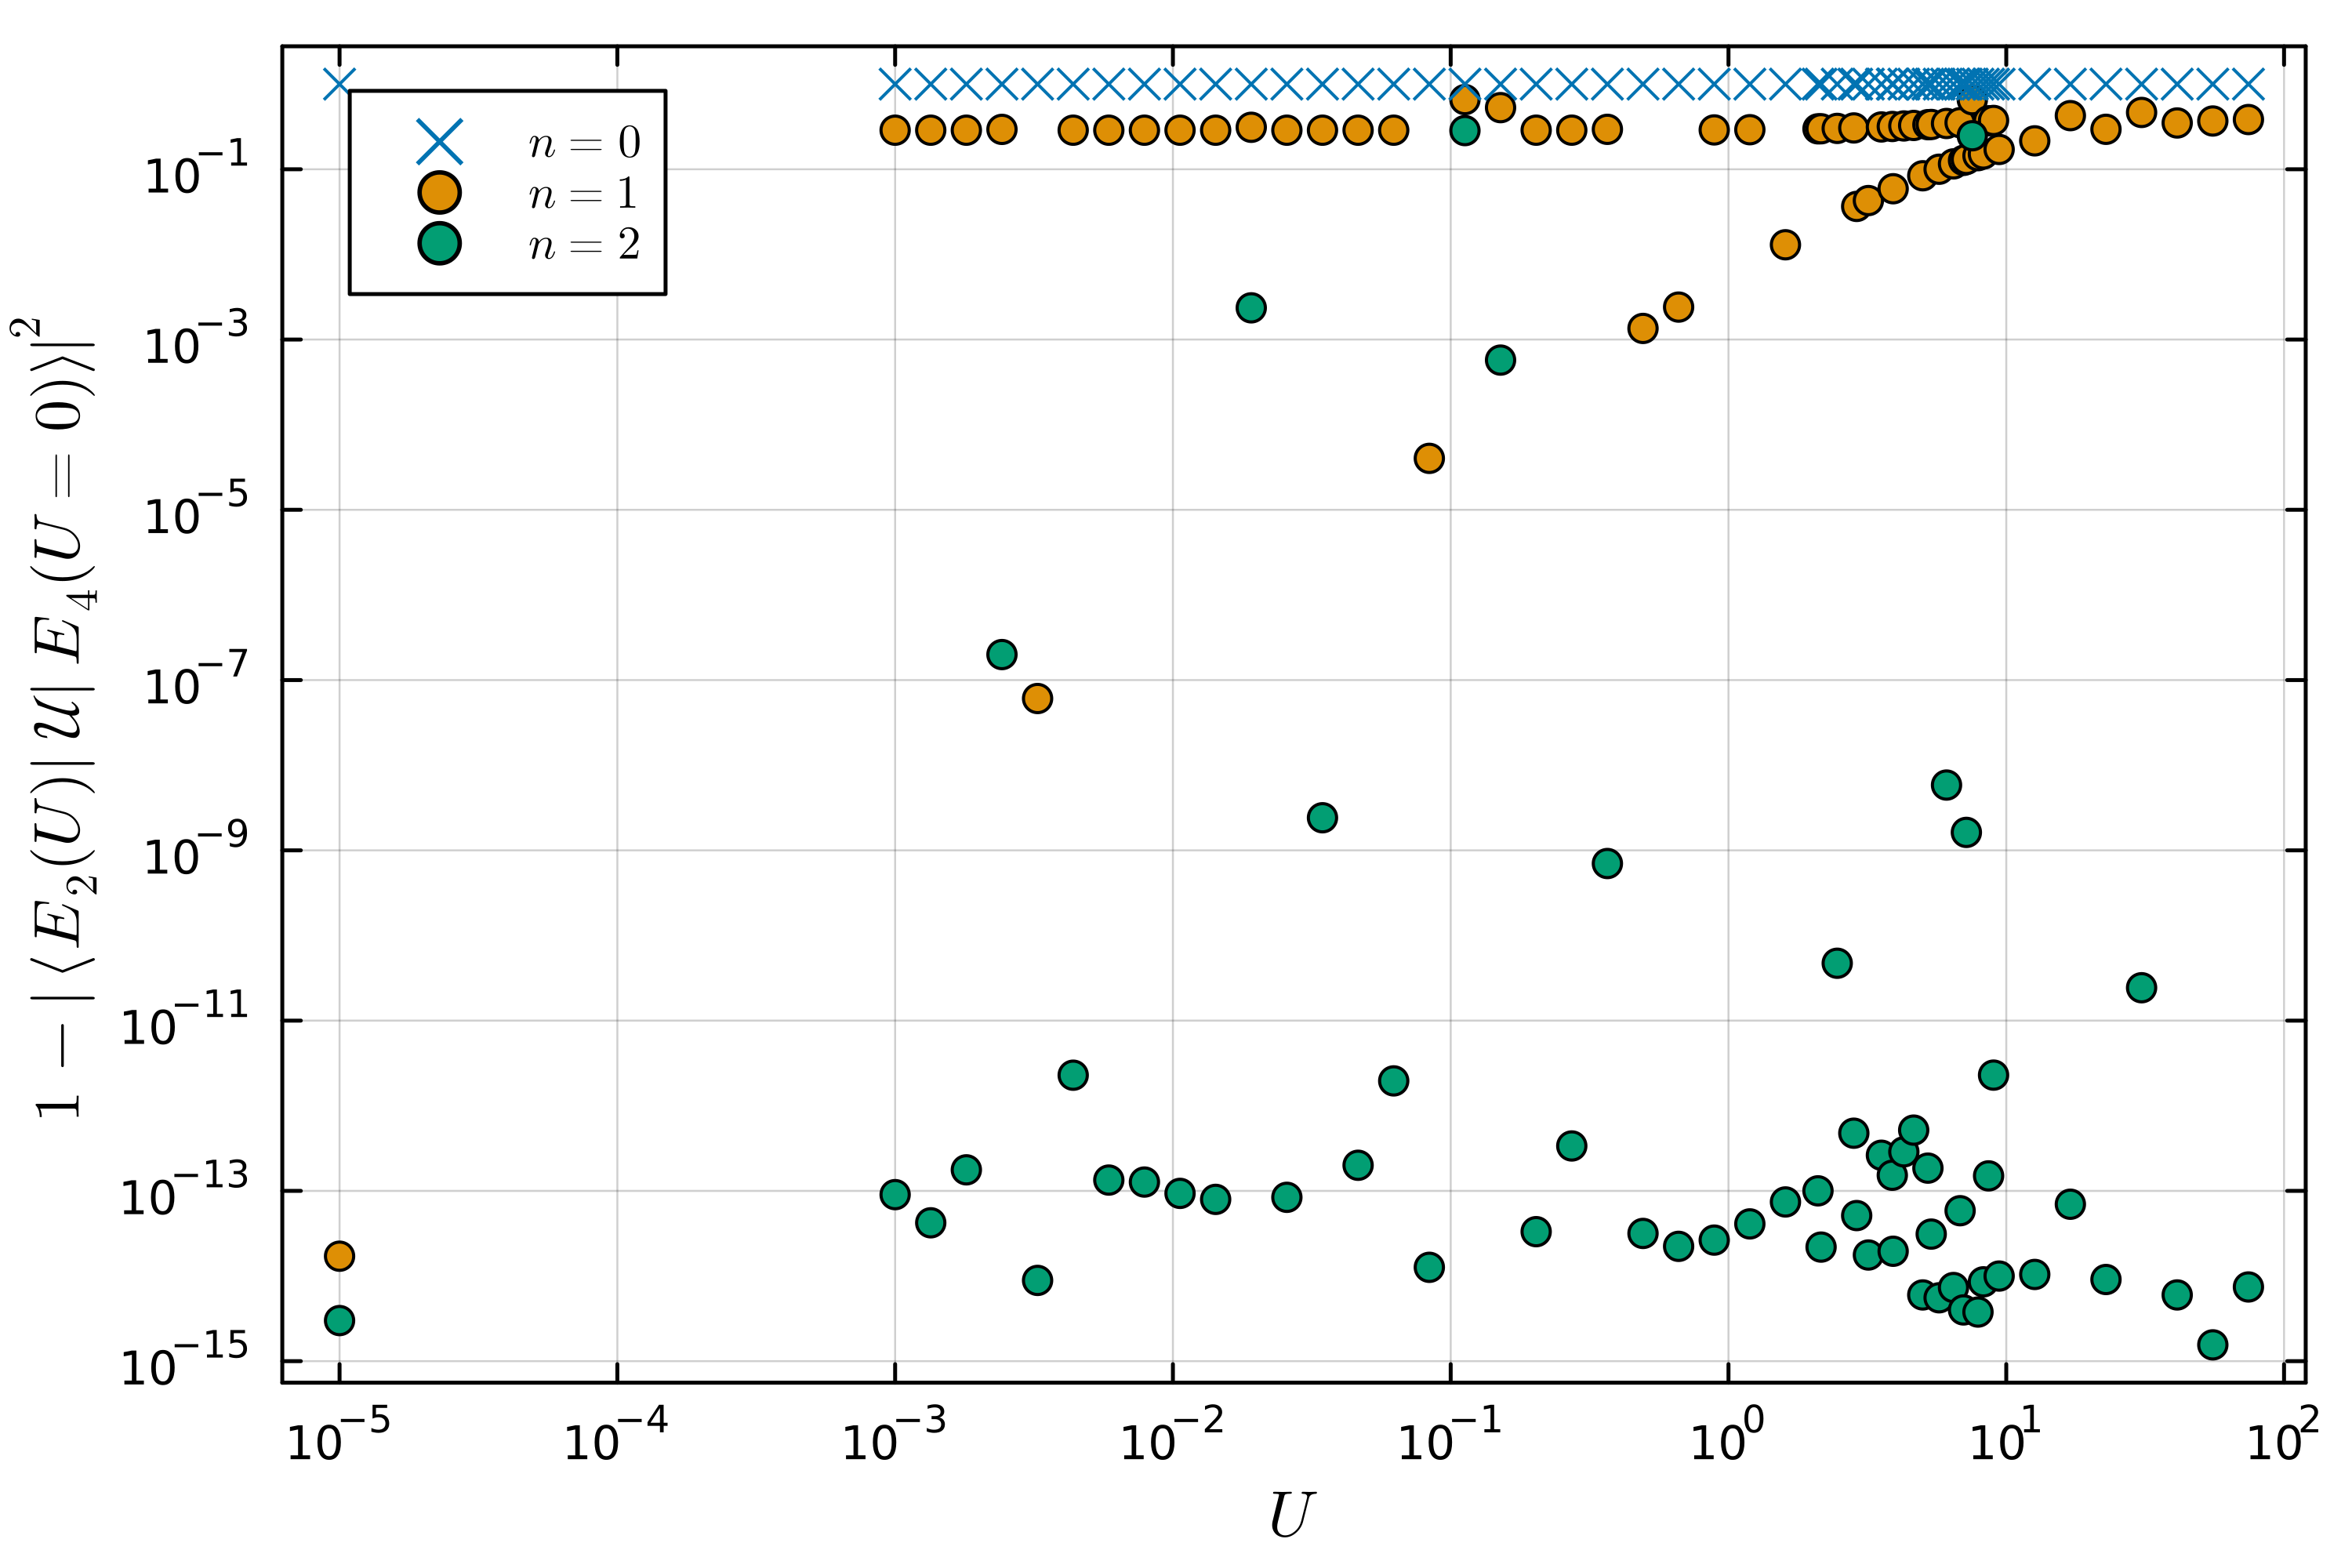

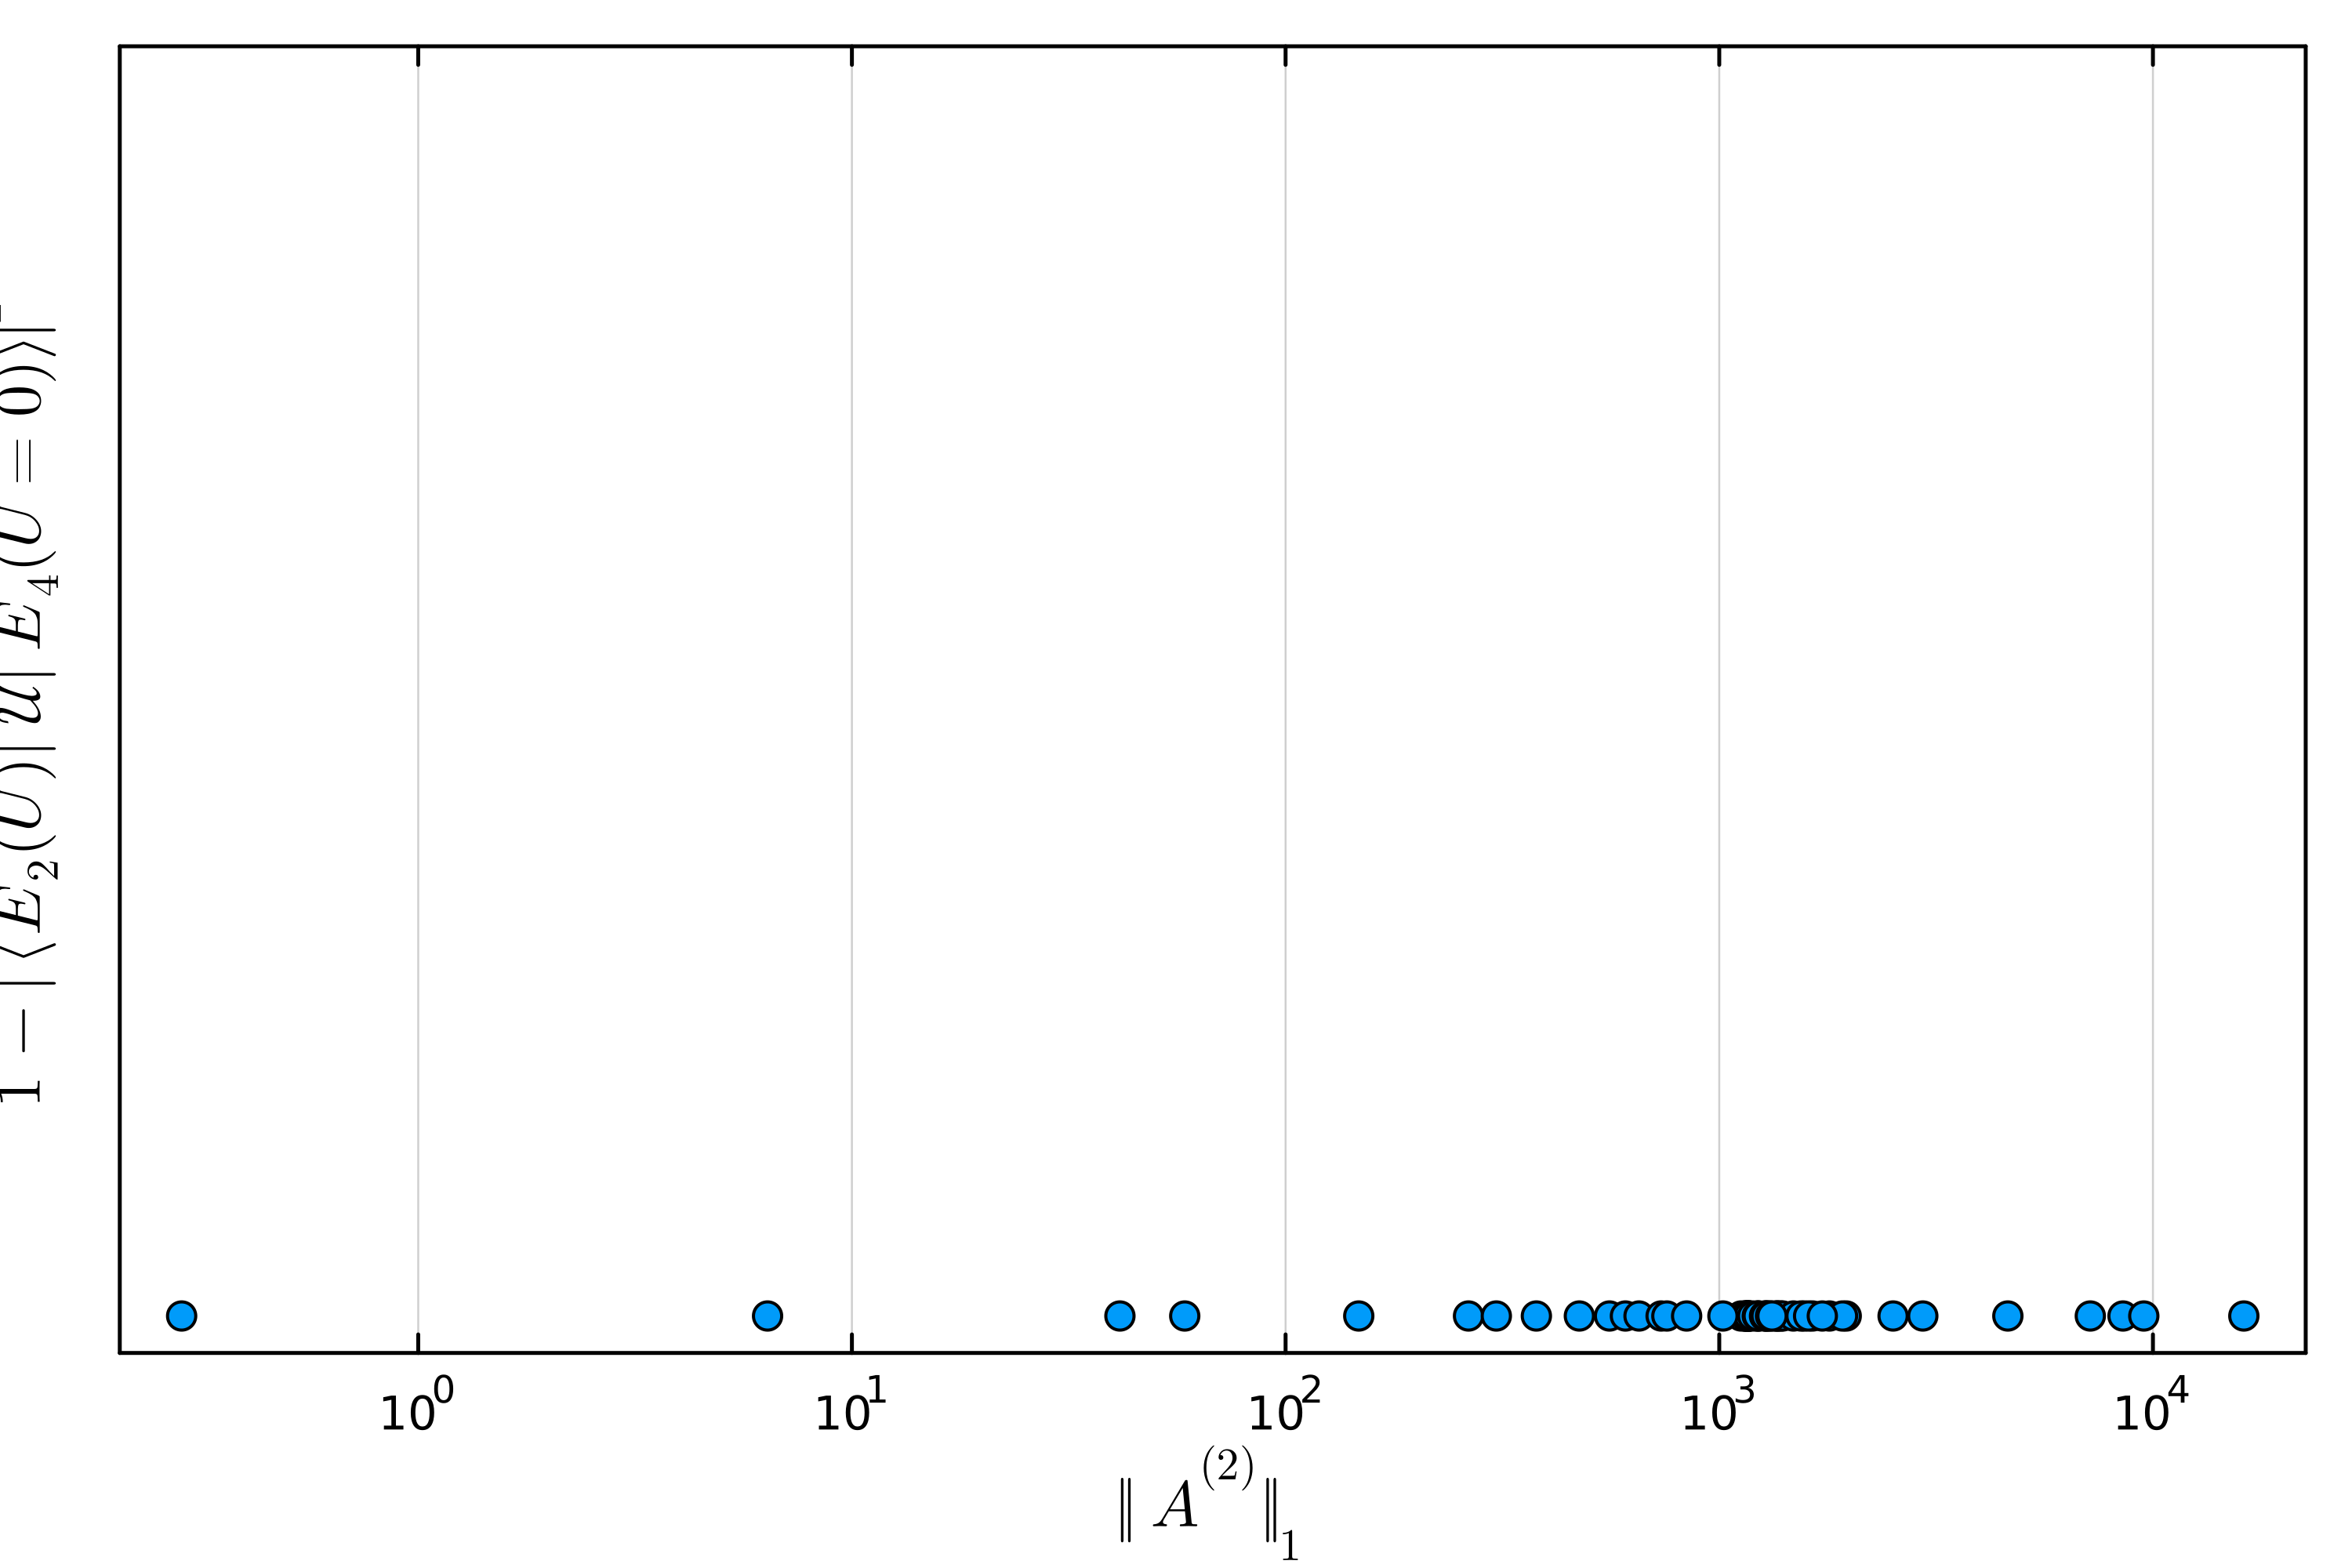

1.709743457922741e-14
1.5543122344752192e-15


In [ ]:
using Glob
n_electrons = 3
target_starting_level = 58
target_ending_level = 46

color_palette = Plots.palette(:seaborn_colorblind)
color_mapping = [color_palette[1], color_palette[2], color_palette[3]] # manually implemented for customization

i = 60
energy_i_map = sortperm(real.(diag(degen_rm_U[i]'*H[i]*degen_rm_U[i])))
inv_map = sortperm(energy_i_map)


# legend_location = :topleft
# p1 = plot(legend=legend_location, xlabel=L"U",yscale=:log10, xscale=:log10, 
#         xticks=10.0 .^(-15:10),yticks=10.0 .^(-15:2:10), 
#          ylabel=L"\Vert A^{(n)}\Vert_1",dpi=500, framestyle=:box)
# p2 = plot(legend=legend_location, ylabel=L"1-|\langle E_{1}(U) |\mathcal{U}|E_{1}(U=0)\rangle|^2",yscale=:log10, xscale=:log10,
#      yticks=10.0 .^(-15:2:10),xticks=10.0 .^(-15:2:10),xlabel=L"\Vert A^{(n)}\Vert_1",dpi=500, framestyle=:box)
# p3 = plot(legend=legend_location, ylabel=L"1-|\langle E_{1}(U) |\mathcal{U}|E_{1}(U=0)\rangle|^2",yscale=:log10, xscale=:log10,
#       yticks=10.0 .^(-15:2:10),xticks=10.0 .^(-15:10),xlabel=L"U",dpi=500, framestyle=:box)
# p4 = plot(legend=nothing, ylabel=L"1-|\langle E_{1}(U) |E_{1}(U=0)\rangle|^2",yscale=:log10, xscale=:log10,
#      yticks=10.0 .^(-15:2:10),xticks=10.0 .^(-15:10),xlabel=L"\Vert A^{(2)}\Vert_1",dpi=500, framestyle=:box)

legend_location = :topleft
p1 = plot(legend=legend_location, xlabel=L"U",yscale=:log10, xscale=:log10, 
        xticks=10.0 .^(-15:10),yticks=10.0 .^(-15:2:10), 
         ylabel=L"\Vert A^{(n)}\Vert_1",dpi=500, framestyle=:box)
p2 = plot(legend=legend_location, ylabel=L"1-|\langle E_{%$(inv_map[target_ending_level])}(U) |\mathcal{U}|E_{%$(inv_map[target_starting_level])}(U=0)\rangle|^2",
    yscale=:log10, xscale=:log10,
     yticks=10.0 .^(-15:2:10),xticks=10.0 .^(-15:2:10),
     xlabel=L"\Vert A^{(n)}\Vert_1",dpi=500, framestyle=:box)
p3 = plot(legend=legend_location, ylabel=L"1-|\langle E_{%$(inv_map[target_ending_level])}(U)|\mathcal{U}|E_{%$(inv_map[target_starting_level])}(U=0)\rangle|^2",
     yscale=:log10, xscale=:log10,
     yticks=10.0 .^(-15:2:10),xticks=10.0 .^(-15:10),
     xlabel=L"U",dpi=500, framestyle=:box)
p4 = plot(legend=nothing, ylabel=L"1-|\langle E_{%$(inv_map[target_ending_level])}(U) |\mathcal{U}|E_{%$(inv_map[target_starting_level])}(U=0)\rangle|^2",
    yscale=:log10, xscale=:log10,
     yticks=10.0 .^(-15:2:10),xticks=10.0 .^(-15:10),
     xlabel=L"\Vert A^{(2)}\Vert_1",dpi=500, framestyle=:box)

initial_loss = abs.(reduce(hcat, data["loss_metrics"])'[:,1])
for i = 1:2
    losses = max.(abs.(reduce(hcat, data["loss_metrics"])'[:,i+1]),1e-15)
    norm_list = reduce(hcat, data["norm1_metrics"])'[:,i]
    _U_values = [U_values[data["labels"][i]["ending state"]["U index"]] for i in eachindex(data["labels"])]

    j = sortperm(_U_values)
    # peak_i = argmax(diff(y[j]))
    # println(U_values[j][peak_i])

    # if i == 2
        scatter!(p1, _U_values[j][3:end], norm_list[j][3:end], label=L"n=%$i", color=color_mapping[i+1])
    # end
    scatter!(p2, norm_list[j], losses[j], label=L"n=%$i", color=color_mapping[i+1])
    if i==1
        scatter!(p3, [],[], label=L"n=0", color=color_mapping[1], marker=:xcross, markersize=4) # plotting nothing to change ordering on legend
    end
    scatter!(p3, _U_values[j], losses[j], label=L"n=%$i", color=color_mapping[i+1])
    println(minimum(losses))
    if i == 1k
        scatter!(p3, _U_values[j], initial_loss[j], label="", color=color_mapping[1], marker=:xcross, markersize=4)
    end

    if i == 2
        scatter!(p4, norm_list[j][3:end], initial_loss[j][3:end])
    end
end

for p in [p1, p2, p3, p4]
    # if p != p2
    #     vline!(p,[5], c="black", linestyle=:dash, label=L"U=5")
    # end
    display(p)
end
variation = "$target_starting_level-$target_ending_level" #"random"
for filetype in ["png", "svg", "pdf"]
    savefig(p1, "single_state_map_images2/U_norm1_$variation.$filetype")
    savefig(p2, "single_state_map_images2/loss_norm1_$variation.$filetype")
    savefig(p3, "single_state_map_images2/U_loss_$variation.$filetype")
    savefig(p4, "single_state_map_images2/overlap_comparison_$variation.$filetype")
end

ED

In [ ]:
t_dict1 = Dict{Vector{Tuple{Coordinate{2,Int64},Int,Symbol}}, Float64}()
for σ1 in 1:2
    for σ2 in 1:2
        for (i,s1) in enumerate(indexer.a)
            for j in i:length(indexer.a)
                s2 = indexer.a[j]
                if [(s1, σ1,:create), (s2, σ2, :annihilate)] ∉ keys(t_dict1)
                    t_dict1[[(s1, σ1,:create), (s2, σ2, :annihilate)]] = 0.5*rand()
                else
                    t_dict1[[(s1, σ1,:create), (s2, σ2, :annihilate)]] += 0.5*rand()
                end
            end
        end
    end
end
# for σ in 1:2
#     for s1 in indexer.a
#         if [(s1, σ,:create), (s1, σ, :annihilate)] ∉ keys(t_dict)
#             t_dict[[(s1, σ,:create), (s1, σ, :annihilate)]] = 100
#         else
#             t_dict[[(s1, σ,:create), (s1, σ, :annihilate)]] += 100
#         end
#     end
# end
t_dict2 = Dict{Vector{Tuple{Coordinate{2,Int64},Int,Symbol}}, Float64}()
for s1 in indexer.a
    if [(s1, 1,:create), (s1, 1, :annihilate),(s1, 2,:create),(s1, 2, :annihilate)] ∉ keys(t_dict2)
        t_dict2[[(s1, 1,:create), (s1, 1, :annihilate),(s1, 2,:create),(s1, 2, :annihilate)]] = 1
    else
        t_dict2[[(s1, 1,:create), (s1, 1, :annihilate),(s1, 2,:create),(s1, 2, :annihilate)]] += 1
    end
end
target_dims = (length(indexer.inv_comb_dict), length(indexer.inv_comb_dict))
rows = Int[]
cols = Int[]
vals = Float64[]
general_n_body!(rows, cols, vals, t_dict1, indexer)
hopping = Matrix(Hermitian(sparse(rows, cols, vals,target_dims..., )))

rows = Int[]
cols = Int[]
vals = Float64[]
general_n_body!(rows, cols, vals, t_dict2, indexer)
interaction = Matrix(Hermitian(sparse(rows, cols, vals,target_dims...)))

EXP(state, M) = state'*M*state
var(state, M) = state'*M^2*state - (state'*M*state)^2
cov(state, A, B) = EXP(state, A*B) - EXP(state, A)*EXP(state, B)
state = normalize(randn(target_dims[1]))
# for i in 1:10000
#     state = normalize(randn(target_dims[1]))
#     if var(state, interaction-hopping) < var(state, interaction)
#         println("worked")
#     end
# end
println(cov(state, hopping, interaction))
println(var(state, hopping))
# size(interaction)


# Adiabatic unitary

In [ ]:
include("adiabatic_analysis.jl")
# using KrylovKit

N_up = 3
N_down = 3
N =  3
half_filling = false
# lattice = Chain(6, Periodic())
lattice_dimension = (2,3)
bc = "periodic"
# lattice = Chain(6, Periodic())
lattice = Square(lattice_dimension, if bc == "periodic" Periodic() else Open() end)
# lattice = Graphs.cycle_graph(3)


hopping_model = HubbardModel(1.0,0.0,0.0,false)
onsite_model = HubbardModel(0.0,1.0,0.0,false)

subspace = HubbardSubspace(N, lattice)
# subspace = HubbardSubspace(N_up, N_down, lattice)

hopping = Matrix(create_Hubbard(hopping_model, subspace))
onsite_potential = Matrix(create_Hubbard(onsite_model, subspace))

@time my_U = time_ordered_unitary(hopping, onsite_potential, 0.0, U_values[26])




In [ ]:
for i=1:50
    x = my_U*degen_rm_U[1][:,i]
    j = argmax(abs.(x))
    phase_difference = (x[j]/abs(x[j]))/degen_rm_U[26][j,i]*abs(degen_rm_U[26][j,i])
    println(sum(abs, x ./ phase_difference - degen_rm_U[26][:,i]))
end

In [ ]:

norm(H[26],1)